In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [4]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)

In [5]:
injected = [50, 0.70]
omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]

signal=1e-22*np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
waveform = qnm_filter.RealData(padded[1], index=padded[0])

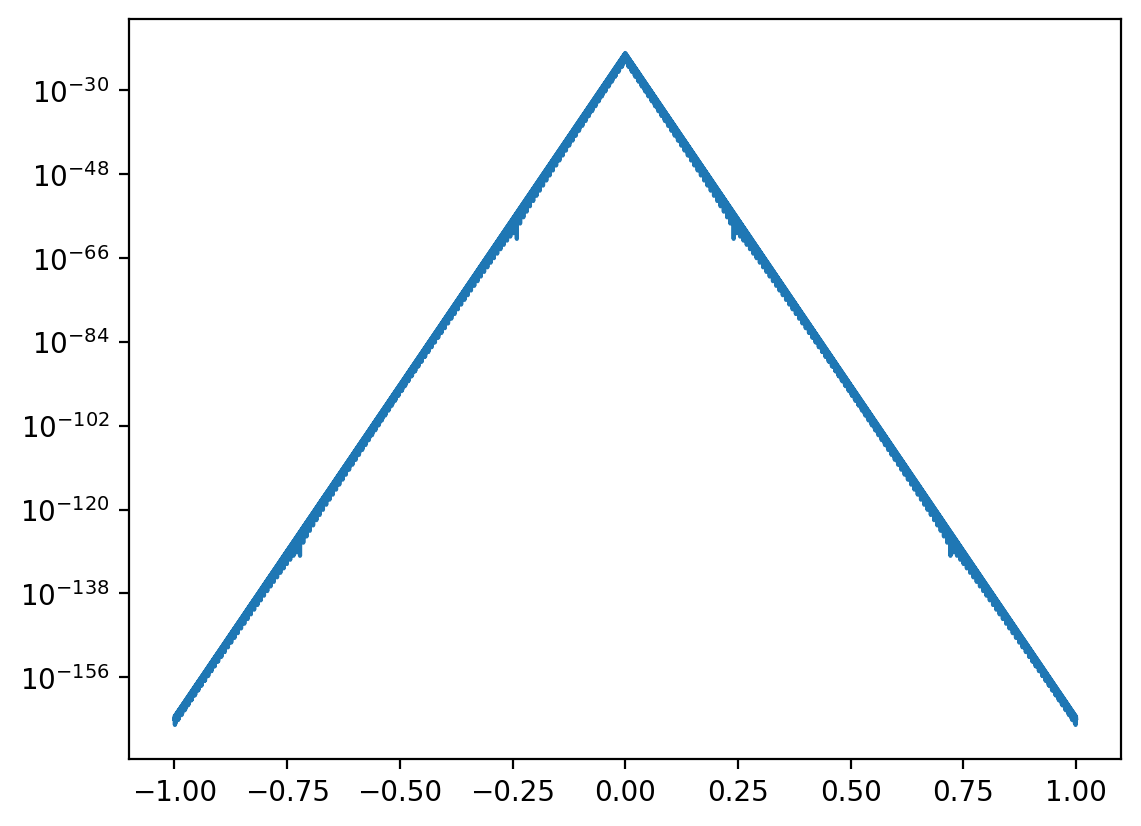

In [6]:
pl.semilogy(t_range, abs(signal))
# pl.xlim(-0.05, 0.05)

In [7]:
fit = qnm_filter.Network()
fit.original_data['H1'] = waveform
fit.add_filter(mass=injected[0], chi=injected[1], 
               model_list = [(2, 2, 0,'p')])

Text(0, 0.5, 'linear scale')

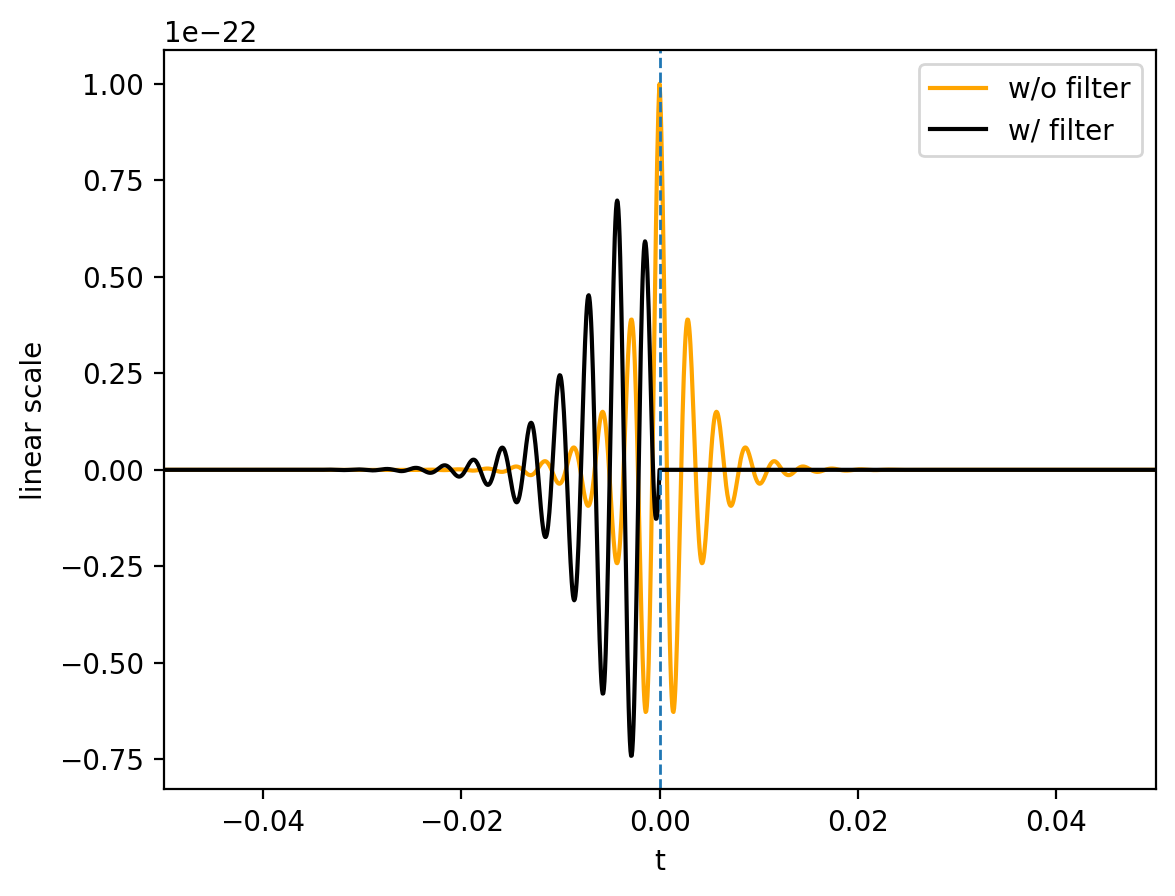

In [8]:
fit.original_data['H1'].plot(color='orange',label='w/o filter')
fit.filtered_data['H1'].plot(color='k',label='w/ filter')
pl.axvline(x=0, ls='--',lw=1)
pl.xlim(-0.05, 0.05)
pl.legend()
pl.xlabel('t')
pl.ylabel('linear scale')
# pl.savefig('ringup_ringdown/ringup_ringdown.pdf',bbox_inches='tight')

(1e-29, 1e-21)

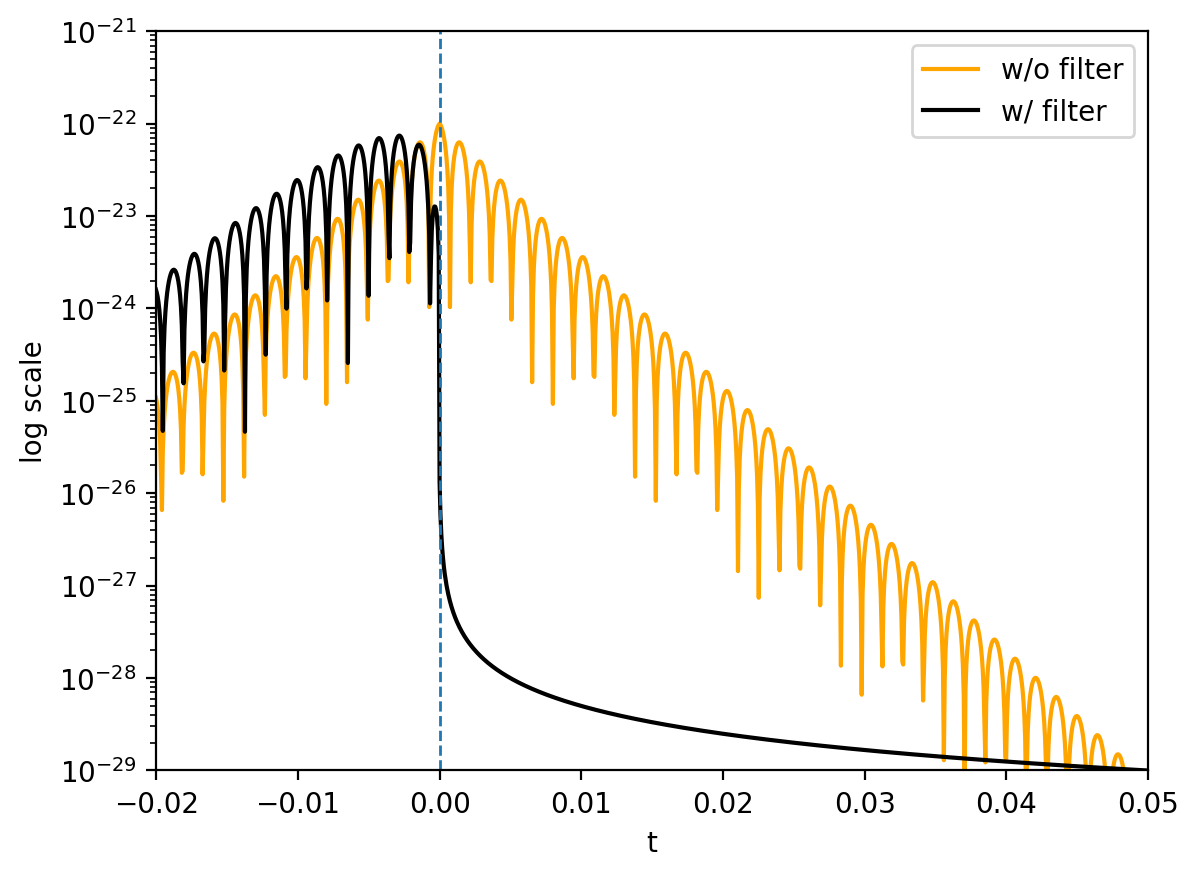

In [9]:
pl.semilogy(t_range,abs(signal),color='orange',label='w/o filter')
pl.semilogy(fit.filtered_data['H1'].index,abs(fit.filtered_data['H1'].values),
            color='k',label='w/ filter')
pl.axvline(x=0, ls='--',lw=1)
pl.legend()
pl.xlabel('t')
pl.ylabel('log scale')
pl.xlim(-0.02,0.05)
pl.ylim(1e-29,1e-21)

In [10]:
mass = qnm_filter.Filter.mass_unit(injected[0])

input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096*4,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 0)

fit = qnm_filter.Network(**input)
fit.original_data['H1'] = waveform
fit.detector_alignment()
# DO NOT CONDITION DATA
fit.compute_acfs('original_data')

In [11]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1*1e-23**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

In [12]:
# # Just for verification
# fit.add_filter(mass=50, chi=0.7, model_list=[(2,2,0,'p')])
# pl.semilogy(fit.original_data['H1'].index,abs(fit.original_data['H1'].values),
#             color='orange',label='w/o filter')
# pl.semilogy(fit.filtered_data['H1'].index,abs(fit.filtered_data['H1'].values),
#             color='k',label='w/ filter')
# pl.legend()
# pl.xlim(-0.02,0.05)
# pl.ylim(1e-29,1e-21)

## Pointwise

In [13]:
# Here the null hypothesis is no signal. So the FF is 0

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
filt_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,0,'p')])
nofilt_likelihood = fit.compute_likelihood(apply_filter=False)

np.isclose(filt_likelihood-nofilt_likelihood, SNR**2/2)

True

In [374]:
# H0 = 220, H1 = 221. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=50, chi=0.7, model_list=[(2,2,1,'p')])
template_res = fit.truncate_data(fit.filtered_data)['H1']
SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
FF = np.sqrt(1-SNR_res**2/SNR**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,1,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,0,'p')])

np.isclose(filt220_likelihood - filt221_likelihood, (1-FF**2)*SNR**2/2)

True

In [375]:
pi = np.pi
w220, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0.7)
w221, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0.7)
B = np.abs((w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220))
phi = np.arccos(np.real(((w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220))/B))
print(B**2*SNR**2, SNR_res**2)

314.9169944381408 340.0071624881186


In [356]:
SNR_res**2/(SNR**2*B**2)

1.0796723215739512

In [378]:
f220 = np.real(w220)/(2*pi)
tau220 = -1/np.imag(w220) * qnm_filter.Filter.mass_unit(injected[0])

In [381]:
wt = tau220*f220*2*pi
(1+wt**2+np.cos(2*phi)-wt*np.sin(2*phi))/(2+wt**2)

0.9876362485570463

In [385]:
f220*2*pi

0.532600243551018

In [383]:
tau220

0.0030482211829447217

In [16]:
# H0 = 220, H1 = 210. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=50, chi=0.7, model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR**2)

filt210_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,1,0,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,0,'p')])

np.isclose(filt220_likelihood - filt210_likelihood, (1-FF**2)*SNR**2/2)

True

In [17]:
# H0 = 210, H1 = 221. Calculate the FF from the residual SNR

fit.add_filter(mass=50, chi=0.7, model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
fit.add_filter(mass=50, chi=0.7, model_list=[(2,2,1,'p')])
template_221 = fit.truncate_data(fit.filtered_data)['H1']
SNR_221 = fit.compute_SNR(None, template_221, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR_221**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,2,1,'p')])
filt210_likelihood = fit.likelihood_vs_mass_spin(50, 0.7, model_list=[(2,1,0,'p')])

np.isclose(filt221_likelihood - filt210_likelihood, 0.5*(SNR_210**2 - SNR_221**2))

True

## Evidence

### 220 vs 221

In [124]:
delta_mass = 0.5
delta_chi = 0.01
massspace = np.arange(30, 100, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [ ]:
# delta_mass = 0.5
# delta_chi = 0.01
# massspace = np.arange(10, 80, delta_mass)
# chispace = np.arange(0.0, 0.99, delta_chi)
# mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [125]:
# H0 = 220, H1 = 221. Calculate the FF from the residual SNR
fit.first_index()
likelihood220, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                          model_list=[(2,2,0,'p')])
likelihood221, evidence221 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                          model_list=[(2,2,1,'p')])
# credible_region = qnm_filter.find_credible_region(likelihood_data)

In [126]:
credible220 = qnm_filter.find_credible_region(likelihood220, target_probability=0.95)
credible221 = qnm_filter.find_credible_region(likelihood221, target_probability=0.95)

In [129]:
template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

ML_mass = mass_grid.flatten()[np.argmax(likelihood221)]
ML_chi = chi_grid.flatten()[np.argmax(likelihood221)]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=[(2,2,1,'p')])
template_221 = fit.truncate_data(fit.filtered_data)['H1']
SNR_221 = fit.compute_SNR(None, template_221, 'H1', optimal=True)
FF = np.sqrt(1-SNR_221**2/SNR**2)

In [130]:
occams220 = (np.count_nonzero(likelihood220>credible220)/len(mass_grid.flatten()))
occams221 = (np.count_nonzero(likelihood221>credible221)/len(mass_grid.flatten()))
ln_BF = evidence220 - evidence221
delta_occams = np.log(occams220) - np.log(occams221)

In [139]:
print((1-FF**2)*SNR**2/2+delta_occams)
print(ln_BF)

2.8599987598334446
2.5919129928296796


### 220 vs 210

In [142]:
# H0 = 220, H1 = 221. Calculate the FF from the residual SNR
fit.first_index()
likelihood210, evidence210 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                          model_list=[(2,1,0,'p')])
credible210 = qnm_filter.find_credible_region(likelihood210, target_probability=0.95)

In [166]:
ML_mass = mass_grid.flatten()[np.argmax(likelihood210)]
ML_chi = chi_grid.flatten()[np.argmax(likelihood210)]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR**2)

occams210 = (np.count_nonzero(likelihood210>credible210)/len(mass_grid.flatten()))
ln_BF = evidence220 - evidence210
delta_occams = np.log(occams220) - np.log(occams210)

In [372]:
print((1-FF**2)*SNR**2/2+delta_occams)
print(ln_BF)

170.0035812440593
{frozenset({210, 221}): -0.899827841258503}


## 220 vs 221+210

In [331]:
delta_mass = 0.5
delta_chi = 0.01
massspace = np.arange(10, 80, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [332]:
H1 = [(2,2,1,'p'), (2,1,0,'p')]
H1_set = frozenset([int(''.join([str(i) for i in j[0:3]])) for j in H1])
likelihood = {}
evidence = {}
credible = {}

In [333]:
# H0 = 220, H1 = 221+210. Calculate the FF from the residual SNR
fit.first_index()
likelihood_temp, evidence_temp = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                          model_list=H1)
credible_temp = qnm_filter.find_credible_region(likelihood_temp, target_probability=0.95)
likelihood[H1_set] = likelihood_temp
evidence[H1_set] = evidence_temp
credible[H1_set] = credible_temp

In [336]:
res_template = {}
res_SNR = {}
FF = {}
occams = {}
ln_BF = {}
delta_occams = {}

In [337]:
ML_mass = mass_grid.flatten()[np.argmax(likelihood[H1_set])]
ML_chi = chi_grid.flatten()[np.argmax(likelihood[H1_set])]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=H1)
res_template[H1_set] = fit.truncate_data(fit.filtered_data)['H1']
res_SNR[H1_set] = fit.compute_SNR(None, res_template[H1_set], 'H1', optimal=True)
FF[H1_set] = np.sqrt(1-res_SNR[H1_set]**2/SNR**2)

occams[H1_set] = (np.count_nonzero(likelihood[H1_set]>credible[H1_set])/len(mass_grid.flatten()))
ln_BF[H1_set] = evidence220 - evidence[H1_set]
delta_occams[H1_set] = np.log(occams220) - np.log(occams[H1_set])

In [338]:
print((1-FF[H1_set]**2)*SNR**2/2+delta_occams[H1_set])
print(ln_BF[H1_set])

-1.015538071764014
-0.899827841258503


In [347]:
delta_occams[H1_set]

-1.0286537000611995